In [1]:
import spacy

In [2]:
spacy.load('en_core_sci_sm')

In [3]:
from gloria.datasets.visualization_utils import *
import pandas as pd
import os
import skimage
from torch import nn

### Get Results Paths

In [4]:
paths = {
    'original_test_none': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_19_58_28/test_outputs_0/',
    'original_test_swapleftright': '/scratch/mcinerney.de/gloria_outputs4/output/gloria_pretrain_1.0/2021_12_14_13_50_54/test_outputs_0/',
    'original_test_shufflebboxes': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_21_00_23/test_outputs_0/',
    'original_test_randsent': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_20_00_44/test_outputs_0/',
    'original_test_randbboxes': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_20_21_48/test_outputs_0/',
#     'original_none': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_11_05_50/val_outputs_0/',
#     'original_none': '/scratch/mcinerney.de/gloria_outputs4/output/gloria_pretrain_1.0/2021_12_07_14_30_56/val_outputs_0/',
#     'original_swapleftright': '/scratch/mcinerney.de/gloria_outputs4/output/gloria_pretrain_1.0/2021_12_14_11_59_40/val_outputs_0/',
#     'original_shufflebboxes': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_16_00_31/val_outputs_0/',
#     'original_shufflebboxes': '/scratch/mcinerney.de/gloria_outputs4/output/gloria_pretrain_1.0/2021_12_07_16_42_14/val_outputs_0/',
#     'original_randsent': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_10_51_31/val_outputs_0/',
#     'original_randsent': '/scratch/mcinerney.de/gloria_outputs4/output/gloria_pretrain_1.0/2021_12_07_14_52_00/val_outputs_0/',
#     'original_randbboxes': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_11_22_47/val_outputs_0/',
#     'original_randbboxes': '/scratch/mcinerney.de/gloria_outputs4/output/gloria_pretrain_1.0/2021_12_07_16_14_30/val_outputs_0/',
#     'retrained_none': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_19_50_12/val_outputs_0/',
#     'retrained_shufflebboxes': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_07_00_24_55/val_outputs_0/',
#     'retrained_randsent': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_22_49_28/val_outputs_0/',
#     'retrained_randbboxes': '/scratch/mcinerney.de/gloria_outputs3/output/gloria_pretrain_1.0/2021_12_06_23_02_34/val_outputs_0/',
#     'retrained_noattn_loss': '/scratch/mcinerney.de/gloria_outputs/output3/gloria_pretrain_1.0//val_outputs_0/'
}


In [5]:
dfs = {k: pd.read_csv(os.path.join(path, 'sentences.csv')) for k, path in paths.items()}

### Get kl divergence with random sentence

### Get Localization Scores

In [6]:
one_lung_selector = OrSelector(
             RowBBoxSelector(contains={'left lung'}, does_not_contain={'right lung'}),
             RowBBoxSelector(contains={'right lung'}, does_not_contain={'left lung'})
         )
abnormal_selector = RowLabelAndContextSelector(contains={('abnormal', 'yes')})
selectors = {'all': None, 'one_lung': one_lung_selector, 'abnormal': abnormal_selector}
# example_df = dfs['original_none']
# selector_counts = {name: len(example_df[example_df.apply(selector, axis=1)])
#                    if selector is not None else len(example_df)
#                    for name, selector in selectors.items()}
example_df = dfs['original_test_none']
selector_counts_test = {name: len(example_df[example_df.apply(selector, axis=1)])
                   if selector is not None else len(example_df)
                   for name, selector in selectors.items()}
score_rows = []
for k, df in dfs.items():
    score_rows.append({'model': k})
    for name, selector in selectors.items():
        rows = df[df.apply(selector, axis=1)] if selector is not None else df
        score_rows[-1]['%s_auroc' % name] = rows.auroc.mean()
        score_rows[-1]['%s_avg_precision' % name] = rows.avg_precision.mean()
        for p in [.1, .2, .3]:
            score_rows[-1]['%s_precision_at_%f' % (name, p)] = rows['precision_at_%f' % p].mean() \
                if 'precision_at_%f' % p in rows.keys() else None
            score_rows[-1]['%s_recall_at_%f' % (name, p)] = rows['recall_at_%f' % p].mean() \
                if 'recall_at_%f' % p in rows.keys() else None
            score_rows[-1]['%s_f1_at_%f' % (name, p)] = rows['f1_at_%f' % p].mean() \
                if 'f1_at_%f' % p in rows.keys() else None
    #     info = path_and_rows_to_info(path, rows=rows)
    #     plot_info(get_attn_overlay, info, path=path)
#     plt.close()
scores_df = pd.DataFrame(score_rows)
# print('val counts', selector_counts)
print('test counts', selector_counts_test)
print(scores_df.keys())
scores_df

test counts {'all': 2496, 'one_lung': 285, 'abnormal': 748}
Index(['model', 'all_auroc', 'all_avg_precision', 'all_precision_at_0.100000',
       'all_recall_at_0.100000', 'all_f1_at_0.100000',
       'all_precision_at_0.200000', 'all_recall_at_0.200000',
       'all_f1_at_0.200000', 'all_precision_at_0.300000',
       'all_recall_at_0.300000', 'all_f1_at_0.300000', 'one_lung_auroc',
       'one_lung_avg_precision', 'one_lung_precision_at_0.100000',
       'one_lung_recall_at_0.100000', 'one_lung_f1_at_0.100000',
       'one_lung_precision_at_0.200000', 'one_lung_recall_at_0.200000',
       'one_lung_f1_at_0.200000', 'one_lung_precision_at_0.300000',
       'one_lung_recall_at_0.300000', 'one_lung_f1_at_0.300000',
       'abnormal_auroc', 'abnormal_avg_precision',
       'abnormal_precision_at_0.100000', 'abnormal_recall_at_0.100000',
       'abnormal_f1_at_0.100000', 'abnormal_precision_at_0.200000',
       'abnormal_recall_at_0.200000', 'abnormal_f1_at_0.200000',
       'abnormal_pre

,model,all_auroc,all_avg_precision,all_precision_at_0.100000,all_recall_at_0.100000,all_f1_at_0.100000,all_precision_at_0.200000,all_recall_at_0.200000,all_f1_at_0.200000,all_precision_at_0.300000,...,abnormal_avg_precision,abnormal_precision_at_0.100000,abnormal_recall_at_0.100000,abnormal_f1_at_0.100000,abnormal_precision_at_0.200000,abnormal_recall_at_0.200000,abnormal_f1_at_0.200000,abnormal_precision_at_0.300000,abnormal_recall_at_0.300000,abnormal_f1_at_0.300000
0,original_test_none,0.690680,0.516796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.482862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,original_test_swapleftright,0.690090,0.516276,0.590486,0.394454,0.411409,0.59624,0.508007,0.499862,0.548927,...,0.480868,0.539606,0.407875,0.406541,0.545306,0.532213,0.496276,0.514405,0.630784,0.507914
2,original_test_shufflebboxes,0.687235,0.516795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.477410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,original_test_randsent,0.681315,0.509981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.467818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,original_test_randbboxes,0.631343,0.452842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.411582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Get Latex tables for Localization Scores

In [7]:
def get_latex_table(prefixes, scores_df):
    latex_table = ''
    model_names = {'original_test': 'GLoRIA', 'original': 'GLoRIA', 'retrained': 'GLoRIA retrained'}
    augmentation_names = {'none': 'None', 'randsent': 'Random Sentences',
                          'shufflebboxes': 'Shuffle Bboxes', 'randbboxes': 'Random Bboxes',
                          'swapleftright': 'Swap Left Right'}
    for i, row in scores_df.iterrows():
        formatted_row_scores = []
        for name in prefixes:
            formatted_row_scores.append(row['%s_auroc' % name])
            formatted_row_scores.append(row['%s_avg_precision' % name])
            formatted_row_scores.append('%.2f/%.2f/%.2f' % tuple(row['%s_precision_at_%f' % (name, p)] * 100 for p in [.1, .2, .3]))
    #             formatted_row_scores.append(row['%s_recall_at_%f' % (name, p)])
    #             formatted_row_scores.append(row['%s_f1_at_%f' % (name, p)])
        augmentation = augmentation_names[row.model.split('_')[-1]]
        model = model_names['_'.join(row.model.split('_')[:-1])]
        formatted_row_scores = '%s & %s & ' % (model, augmentation) + ' & '.join(['%.2f' % (s * 100) if isinstance(s, float) else str(s) for s in formatted_row_scores])
        latex_table += formatted_row_scores + ' \\\\\n'
    print(latex_table)

print('all')
get_latex_table(['all'], scores_df)
print('one_lung')
get_latex_table(['one_lung'], scores_df)
print('abnormal')
get_latex_table(['abnormal'], scores_df)

all
GLoRIA & None & 69.07 & 51.68 & nan/nan/nan \\
GLoRIA & Swap Left Right & 69.01 & 51.63 & 59.05/59.62/54.89 \\
GLoRIA & Shuffle Bboxes & 68.72 & 51.68 & nan/nan/nan \\
GLoRIA & Random Sentences & 68.13 & 51.00 & nan/nan/nan \\
GLoRIA & Random Bboxes & 63.13 & 45.28 & nan/nan/nan \\

one_lung
GLoRIA & None & 65.48 & 38.67 & nan/nan/nan \\
GLoRIA & Swap Left Right & 65.24 & 38.40 & 42.48/43.42/39.33 \\
GLoRIA & Shuffle Bboxes & 65.41 & 39.01 & nan/nan/nan \\
GLoRIA & Random Sentences & 64.97 & 37.88 & nan/nan/nan \\
GLoRIA & Random Bboxes & 59.94 & 35.12 & nan/nan/nan \\

abnormal
GLoRIA & None & 69.51 & 48.29 & nan/nan/nan \\
GLoRIA & Swap Left Right & 69.34 & 48.09 & 53.96/54.53/51.44 \\
GLoRIA & Shuffle Bboxes & 68.65 & 47.74 & nan/nan/nan \\
GLoRIA & Random Sentences & 67.42 & 46.78 & nan/nan/nan \\
GLoRIA & Random Bboxes & 61.95 & 41.16 & nan/nan/nan \\



### Get Candidate Matching Scores

In [8]:
matching_scores = []
for base in ['original_test']:
    matching_scores.append({'model': base})
    combined = pd.merge(dfs['%s_none' % base], dfs['%s_randsent' % base].rename(
        columns=lambda x: 'neg_' + x), left_on='dicom_sent_id', right_on='neg_dicom_sent_id')
    for n, selector in selectors.items():
        rows = combined[combined.apply(selector, axis=1)] if selector is not None else combined
        matching_scores[-1]['%s_local_acc' % n] = (rows.local_sims > rows.neg_local_sims).mean()
        matching_scores[-1]['%s_global_acc' % n] = (rows.global_sims > rows.neg_global_sims).mean()
matching_scores = pd.DataFrame(matching_scores)
latex_table = ''
model_names = {'original_test': 'GLoRIA', 'original': 'GLoRIA', 'retrained': 'GLoRIA retrained'}
for i, row in matching_scores.iterrows():
    latex_table += '%s & ' % model_names[row.model] + ' & '.join([
        '%.1f' % (row[col] * 100) for col in [
            'all_local_acc', 'all_global_acc',
            'one_lung_local_acc', 'one_lung_global_acc',
            'abnormal_local_acc', 'abnormal_global_acc',
        ]
    ]) + ' \\\\\n'
print(latex_table)
matching_scores

GLoRIA & 54.4 & 71.9 & 41.4 & 75.1 & 42.1 & 77.9 \\



,model,all_local_acc,all_global_acc,one_lung_local_acc,one_lung_global_acc,abnormal_local_acc,abnormal_global_acc
0,original_test,0.544071,0.71875,0.414035,0.750877,0.421123,0.779412


### Get Correlations

In [9]:
correlation_rows = []
for base in ['original_test']:
    correlation_rows.append({'model': base})
    local_bce = np.log((pd.concat([dfs['%s_none' % base].local_sims / 5, 1 - (dfs['%s_randsent' % base].local_sims / 5)]) + 1) / 2)
    global_bce = np.log((pd.concat([dfs['%s_none' % base].global_sims, 1 - dfs['%s_randsent' % base].global_sims]) + 1) / 2)
#     local_bce = (pd.concat([dfs['%s_none' % base].local_sims / 5, 1 - (dfs['%s_randsent' % base].local_sims / 5)]) + 1) / 2
#     global_bce = (pd.concat([dfs['%s_none' % base].global_sims, 1 - dfs['%s_randsent' % base].global_sims]) + 1) / 2
    avg_precision = pd.concat([dfs['%s_none' % base].avg_precision, dfs['%s_randsent' % base].avg_precision])
    auroc = pd.concat([dfs['%s_none' % base].auroc, dfs['%s_randsent' % base].auroc])
    attn_entropy = pd.concat([dfs['%s_none' % base].attn_entropy, dfs['%s_randsent' % base].attn_entropy])
    correlation_rows[-1]['local_matching_bce_and_global_matching_bce'] = local_bce.corr(global_bce)
    for name, bce in [('local', local_bce), ('global', global_bce)]:
        correlation_rows[-1]['%s_matching_bce_and_attn_entropy' % name] = bce.corr(attn_entropy)
        correlation_rows[-1]['%s_matching_bce_and_avg_precision' % name] = bce.corr(avg_precision)
        correlation_rows[-1]['%s_matching_bce_and_auroc' % name] = bce.corr(auroc)
    correlation_rows[-1]['attn_entropy_and_auroc'] = attn_entropy.corr(auroc)
    correlation_rows[-1]['attn_entropy_and_avg_precision'] = attn_entropy.corr(avg_precision)
    correlation_rows[-1]['auroc_and_avg_precision'] = auroc.corr(avg_precision)
correlation_df = pd.DataFrame(correlation_rows)
latex_table = ''
model_names = {'original_test': 'GLoRIA', 'original': 'GLoRIA', 'retrained': 'GLoRIA retrained'}
metrics = ['local_matching_bce', 'global_matching_bce', 'attn_entropy', 'auroc', 'avg_precision']
metric_names = {
    'local_matching_bce': 'Local Matching BCE',
    'global_matching_bce': 'Global Matching BCE',
    'attn_entropy': 'Attn Entropy',
    'auroc': 'AUROC',
    'avg_precision': 'Avg Precision',
}
latex_table = '& ' + ' & '.join([metric_names[m] for m in metrics[:-1]]) + ' \\\\\n'
for i, row in correlation_df.iterrows():
    latex_table += '\\hline\n%s \\\\\n\\hline\n' % model_names[row.model]
    for metric2 in metrics[1:]:
        latex_table += '%s & ' % metric_names[metric2] + ' & '.join([
            '%.3f' % row[(metric1 + '_and_' + metric2)]
            if (metric1 + '_and_' + metric2) in row.keys() else ''
            for metric1 in metrics[:-1]
        ]) + ' \\\\\n'
print(latex_table)
correlation_df


& Local Matching BCE & Global Matching BCE & Attn Entropy & AUROC \\
\hline
GLoRIA \\
\hline
Global Matching BCE & -0.631 &  &  &  \\
Attn Entropy & 0.080 & -0.011 &  &  \\
AUROC & 0.053 & -0.044 & 0.092 &  \\
Avg Precision & 0.026 & -0.047 & 0.028 & 0.621 \\



,model,local_matching_bce_and_global_matching_bce,local_matching_bce_and_attn_entropy,local_matching_bce_and_avg_precision,local_matching_bce_and_auroc,global_matching_bce_and_attn_entropy,global_matching_bce_and_avg_precision,global_matching_bce_and_auroc,attn_entropy_and_auroc,attn_entropy_and_avg_precision,auroc_and_avg_precision
0,original_test,-0.631491,0.080232,0.026347,0.053078,-0.010838,-0.046573,-0.044436,0.091763,0.028466,0.620504


## Visualize Attention

In [10]:
from omegaconf import OmegaConf
import gloria
from gloria.datasets.mimic_for_gloria import GloriaCollateFn
from gloria.lightning.callbacks import EvaluateLocalization
from gloria.lightning.pretrain_model import PretrainModel
import matplotlib.pyplot as plt

def get_instance(dicom_id, sent_id, dataset, randomize_objects_mode=None, swap_left_right=False, generate_sent=False,
                 swap_conditions=False, replace_sent_with=None):
    rows = dataset.df[dataset.df.dicom_id == dicom_id]
    instance = dataset.get_item_from_rows(rows)
    instance = dataset.add_objects(instance, sent_id=sent_id, randomize_objects_mode=randomize_objects_mode,
            swap_left_right=swap_left_right, generate_sent=generate_sent,
            swap_conditions=swap_conditions)
    if replace_sent_with is not None:
        patient_id = next(iter(instance.keys()))
        study_id = next(iter(instance[patient_id].keys()))
        instance[patient_id][study_id]['sentence'] = replace_sent_with
    return instance

def produce_visual_results(module, dataset, dicom_sent_ids, directory='experiments'):
    os.mkdir(directory)
    experiments = {
#         'reg': {},
#         'randsent': dict(randomize_objects_mode='random_sentences'),
#         'swapleftright': dict(swap_left_right=True),
        'gensent': dict(generate_sent=True),
        'swapcond': dict(generate_sent=True, swap_conditions=True),
        'donkeys': dict(replace_sent_with='Donkeys like to fly kites.'),
    }
    for k, kwargs in experiments.items():
        el.evaluate_and_save(
            path=directory + '/' + k, instances=[
                get_instance(*dicom_sent_id.split('_')[1::2], dataset, **kwargs)
                for dicom_sent_id in dicom_sent_ids],
            pl_module=module, save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')
    return {k: directory + '/' + k for k in experiments.keys()}

def display(instance):
    patient_id = next(iter(instance.keys()))
    study_id = next(iter(instance[patient_id].keys()))
    print(instance[patient_id][study_id]['sentence'])
    img = instance[patient_id][study_id]['images'][dicom_id]
    plt.imshow(to_rgb(img))

import os
from jupyter_innotater import *
import pandas as pd

def visualize(model_paths, selector=None):
    min_list_of_files = None
    for model_path in model_paths.values():
        fs = set(os.listdir(os.path.join(model_path, 'sentence_figures')))
        df = pd.read_csv(os.path.join(model_path, 'sentences.csv'))
        if selector is not None:
            df = df[df.apply(selector, axis=1)]
        fs = fs.intersection(set([dicom_sent_id + '.jpg' for dicom_sent_id in set(df.dicom_sent_id)]))
        if min_list_of_files is None:
            min_list_of_files = fs
        else:
            min_list_of_files = min_list_of_files.intersection(fs)
    min_list_of_files = sorted(list(min_list_of_files))
    innotations = [
        innotation
        for model_name, model_path in model_paths.items()
        for innotation in [
            TextInnotation([model_name] * len(min_list_of_files)),
            TextInnotation(min_list_of_files),
            ImageInnotation(min_list_of_files, path=os.path.join(model_path, 'sentence_figures'))
        ]
    ]
    return Innotater(
        innotations,
        []
    )

In [30]:
cfg = OmegaConf.load('configs/imagenome_pretrain_config.yaml')
cfg.data.generate_sent = True
cfg.data.swap_conditions = True
cfg.data.mask_mode = 'clinical'
dm = gloria.builder.build_data_module(cfg)
collate_fn = GloriaCollateFn(cfg, "test")
el = EvaluateLocalization(collate_fn)
module = PretrainModel.load_from_checkpoint('./pretrained/chexpert_resnet50.ckpt')
module = module.eval()
gold = dm.dm.get_dataset('gold')

downloaded


/home/mcinerney.de/.conda/envs/gloria/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mcinerney.de/.conda/envs/gloria/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/home/mcinerney.de/.conda/envs/gloria/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/mcinerney.de/.conda/envs/gloria/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thresholds = tensor(reversed(thresholds[sl]))
/home/mcinerney.de/.conda/envs/gloria/lib/python3.8/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either mo

/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/visualization_utils.py:541: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, 'sentence_figures', dicom_sent_id + '.jpg'))
 10%|█         | 1/10 [00:00<00:07,  1.15it/s]/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/visualization_utils.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_attn = torch.tensor(attn)
/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/visualization_utils.py:541: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig(os.path.join(path, 'sentence_figures', dicom_sent_id + '.jpg'))
 20%|██        | 2/10 [00:01<00:05,  1.43it/s]/home/mci

 30%|███       | 3/10 [00:01<00:04,  1.65it/s]/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/visualization_utils.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_attn = torch.tensor(attn)
 40%|████      | 4/10 [00:02<00:03,  1.75it/s]/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/visualization_utils.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_attn = torch.tensor(attn)
 50%|█████     | 5/10 [00:02<00:02,  1.80it/s]/home/mcinerney.de/Documents/projects/gloria/gloria/datasets/visualization_utils.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

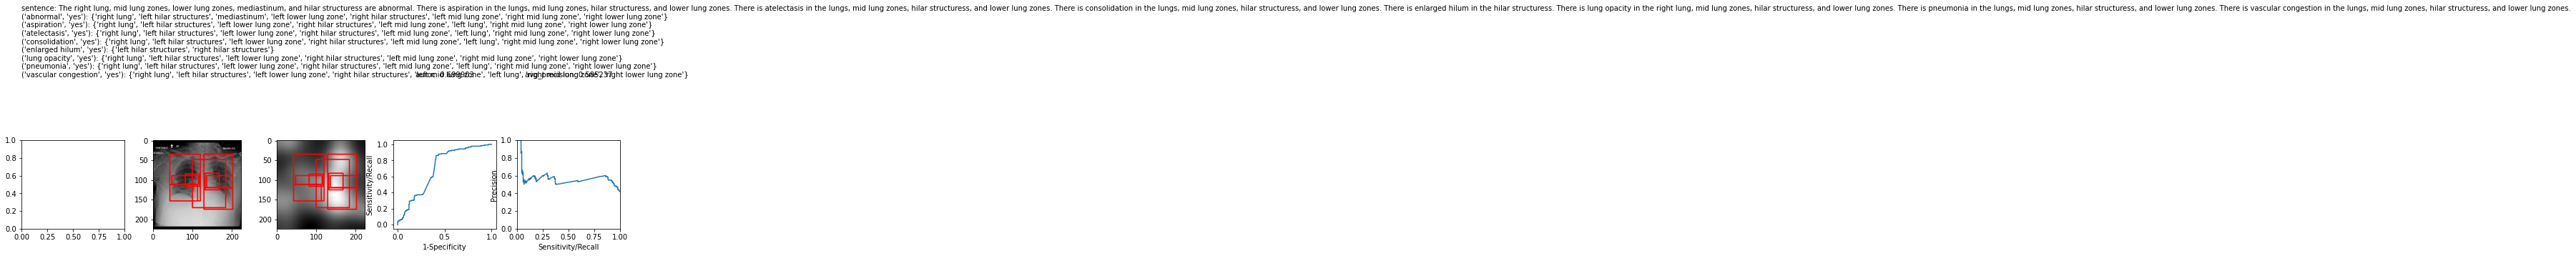

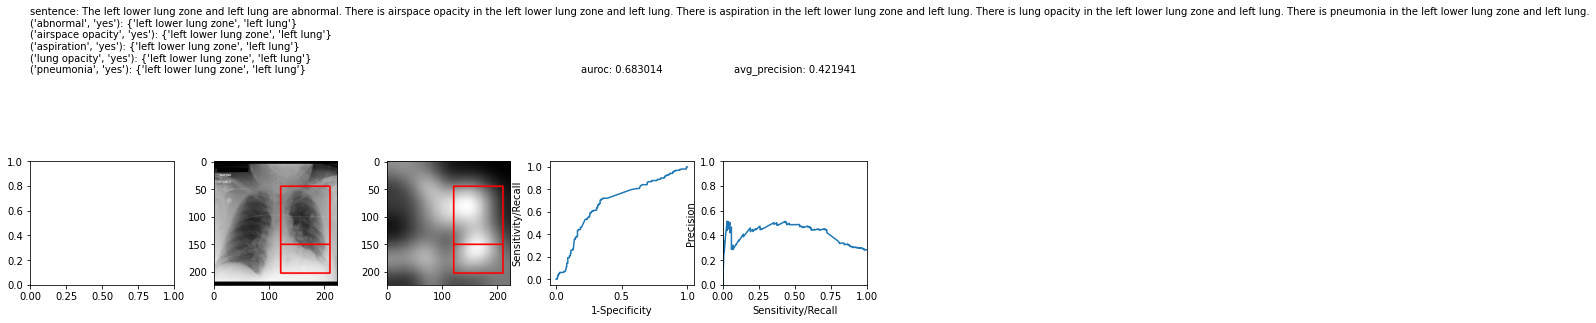

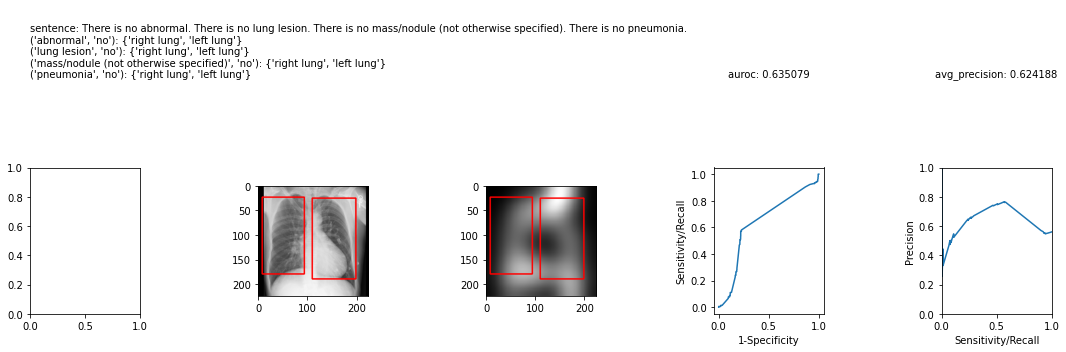

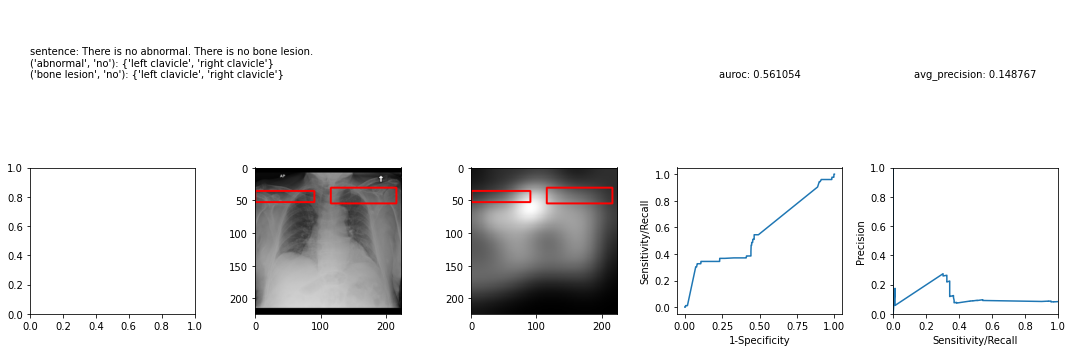

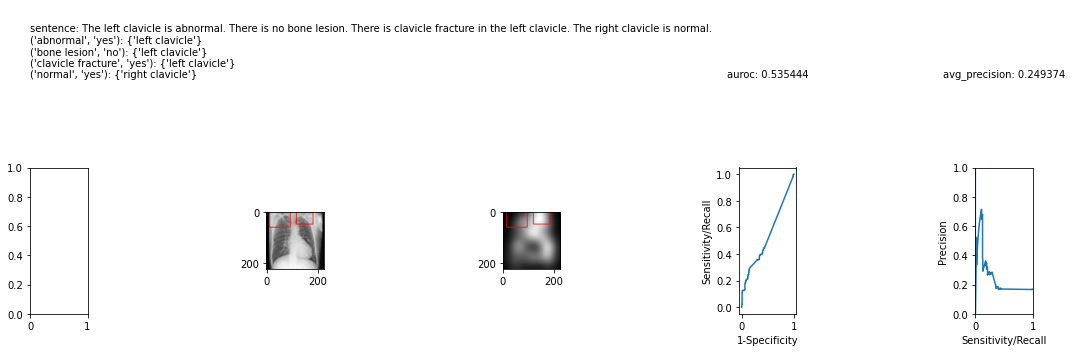

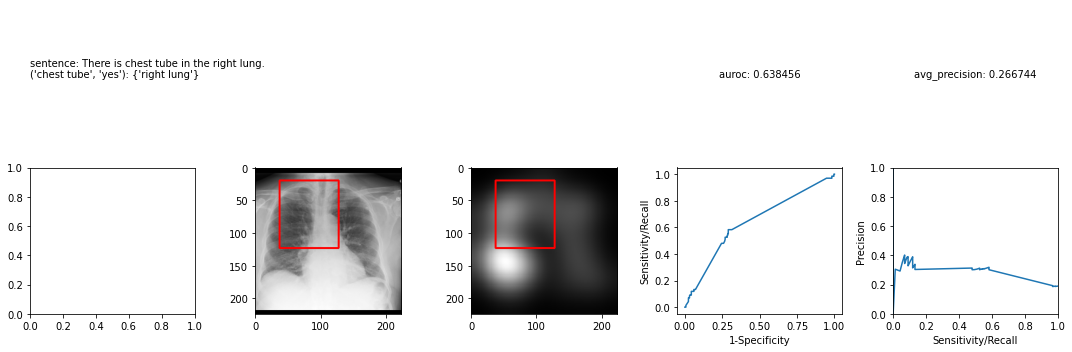

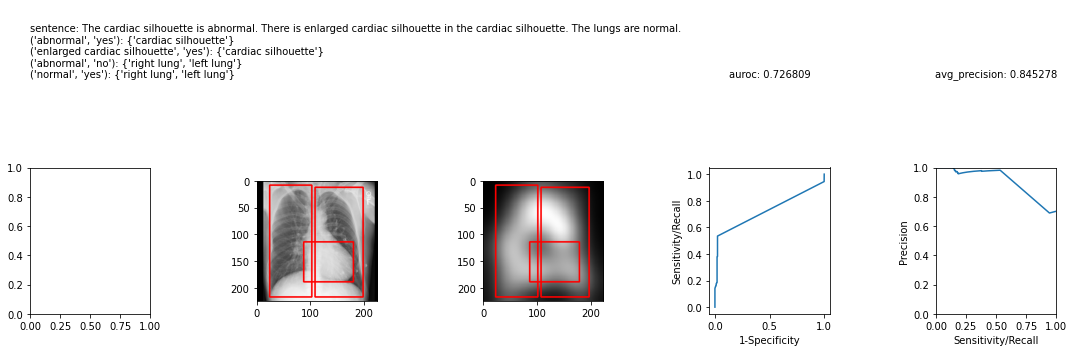

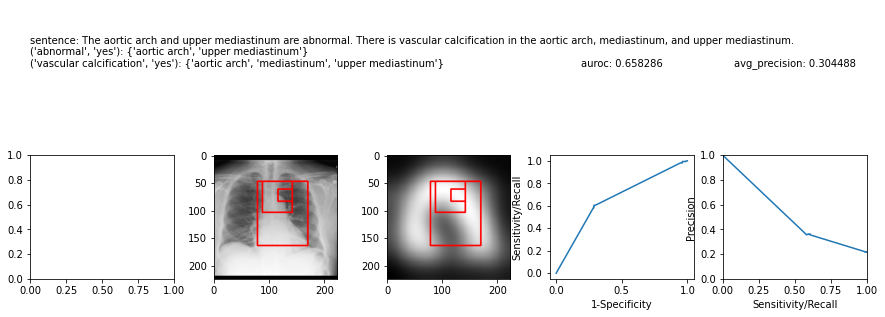

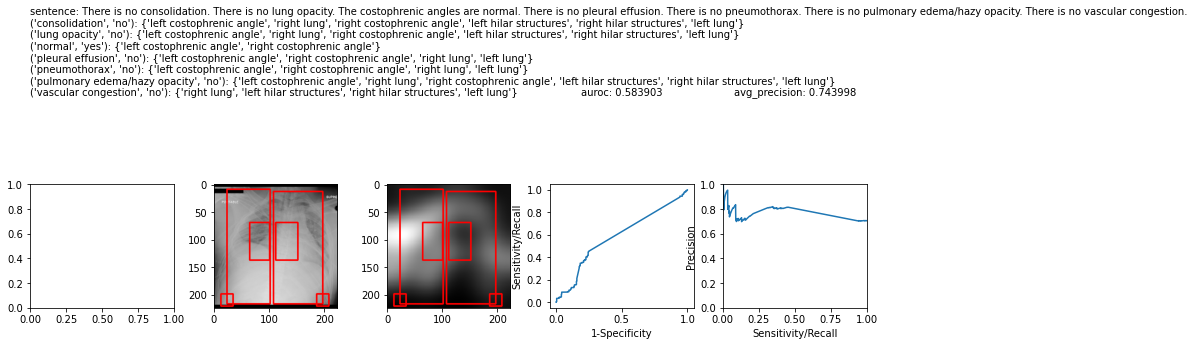

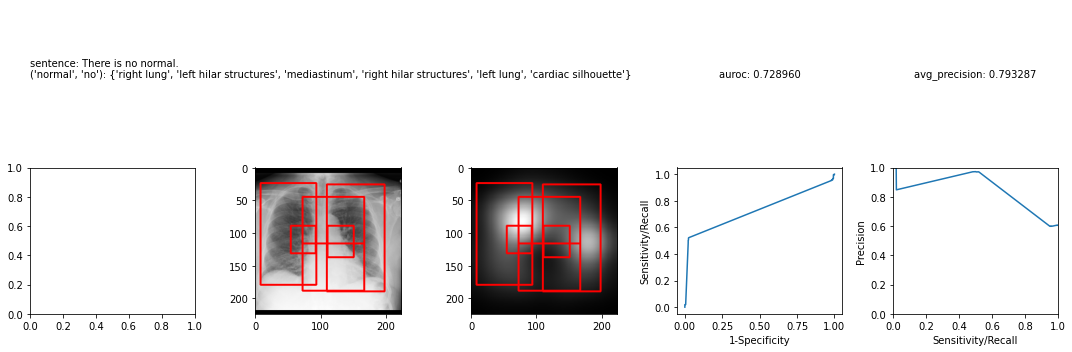

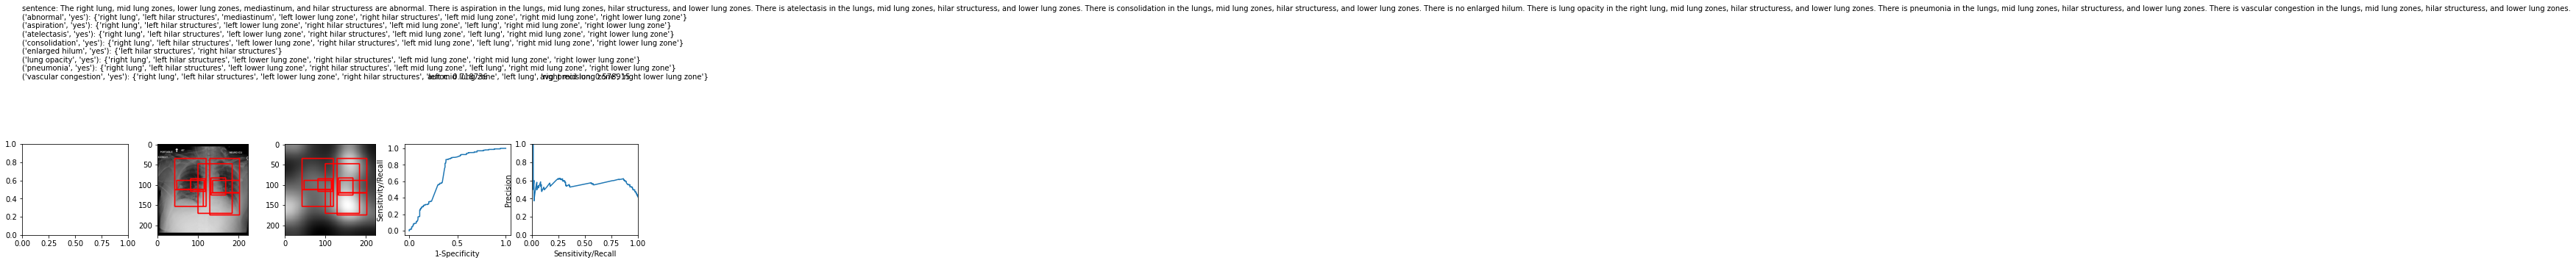

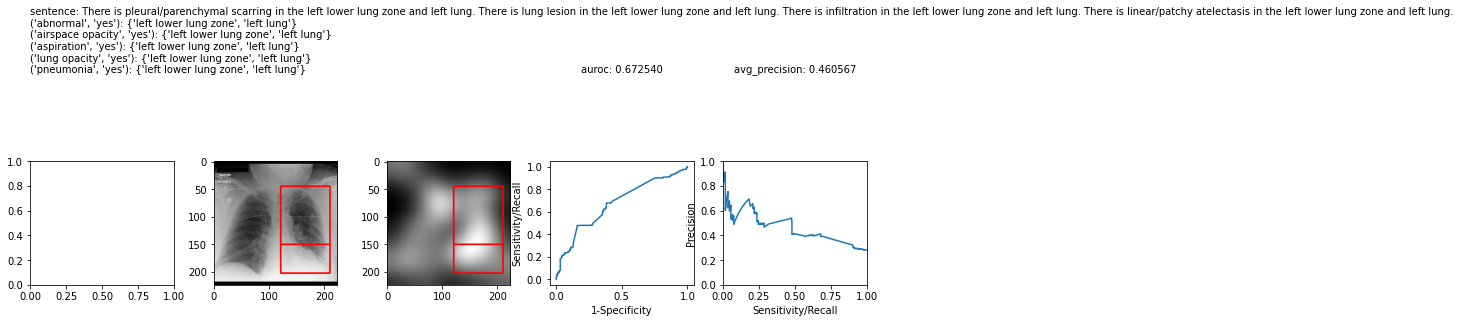

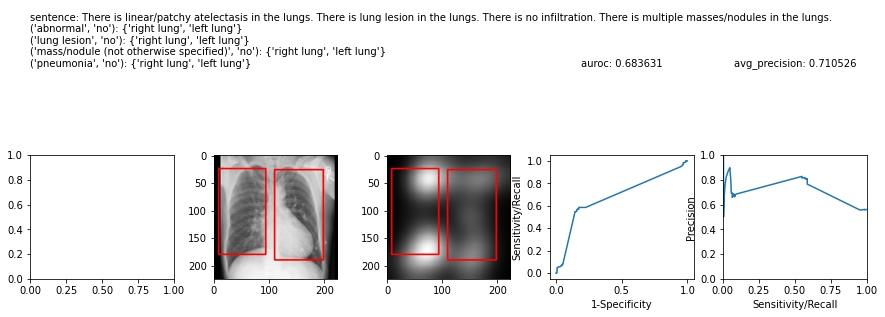

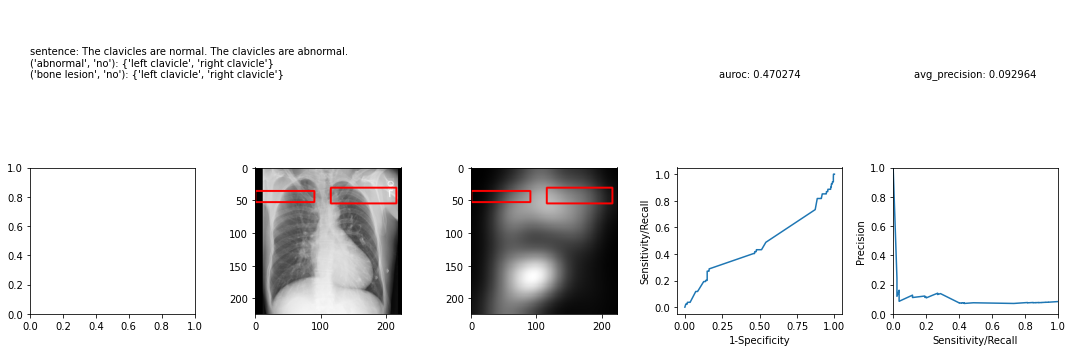

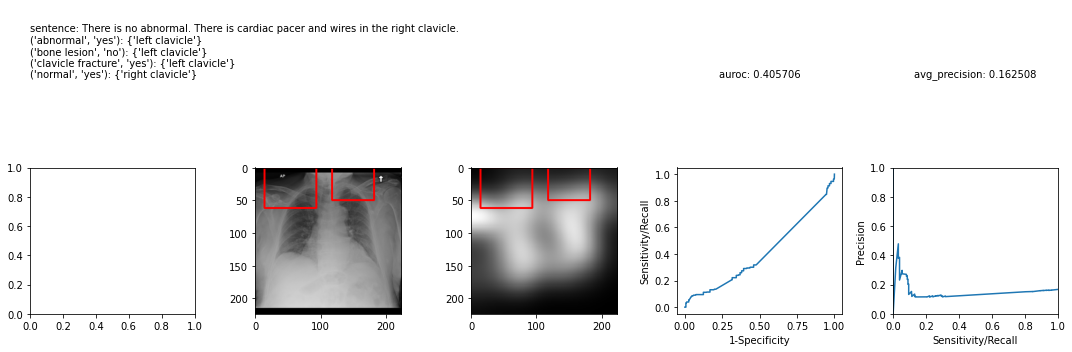

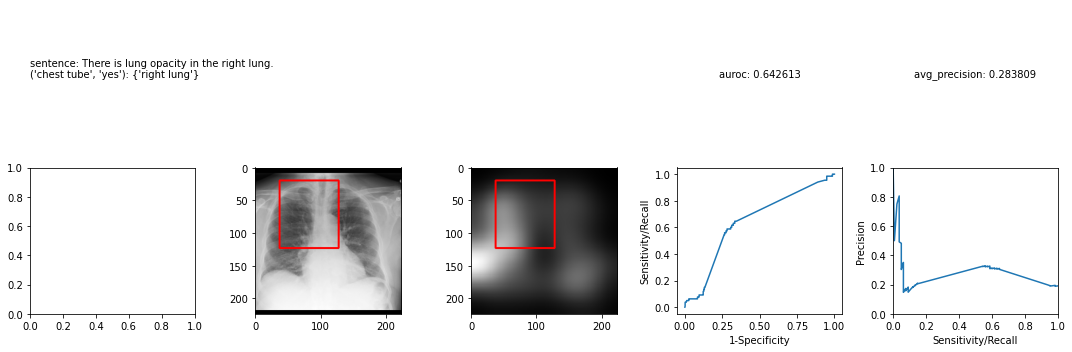

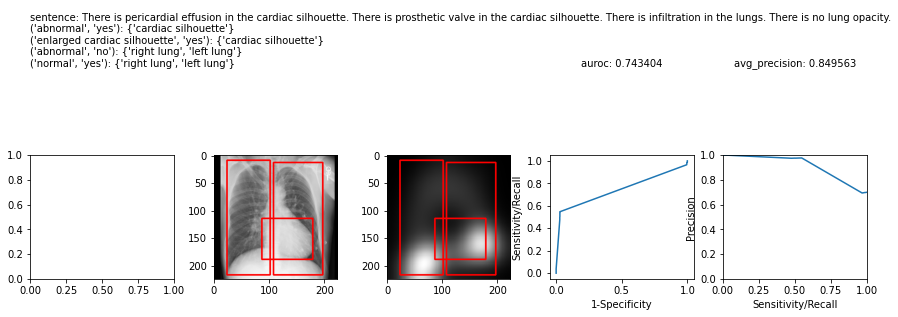

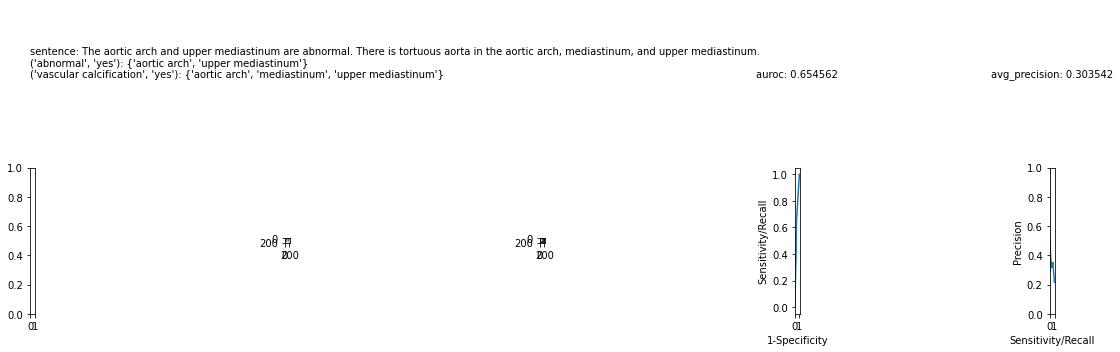

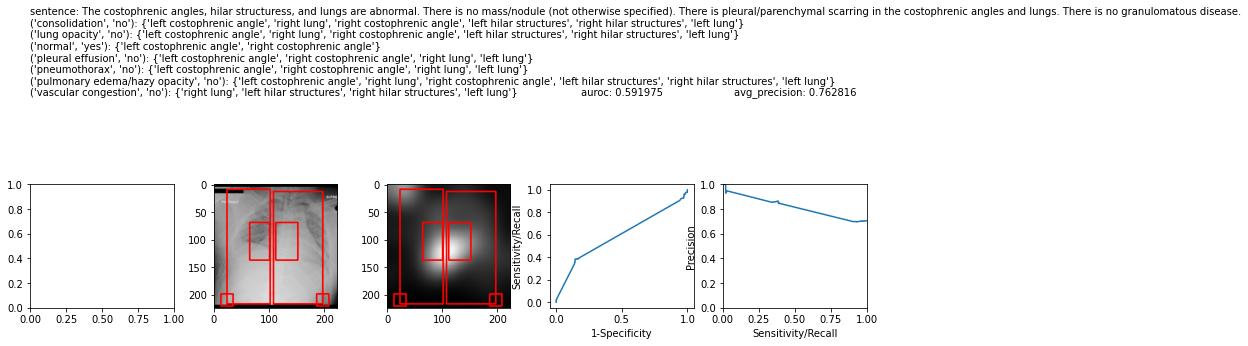

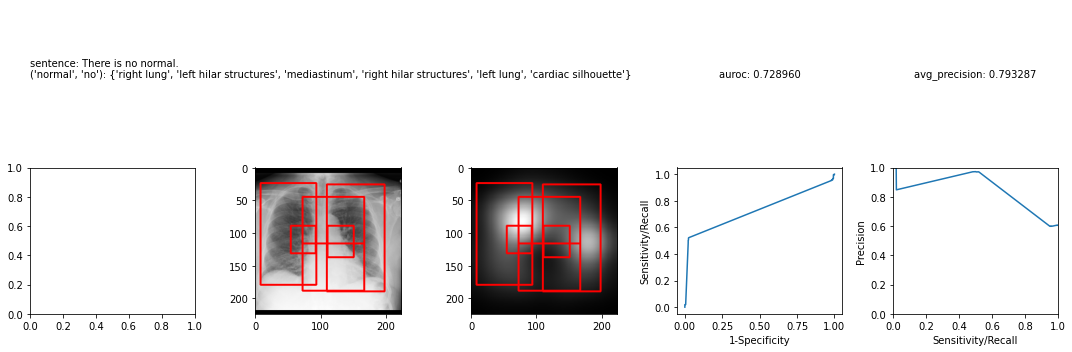

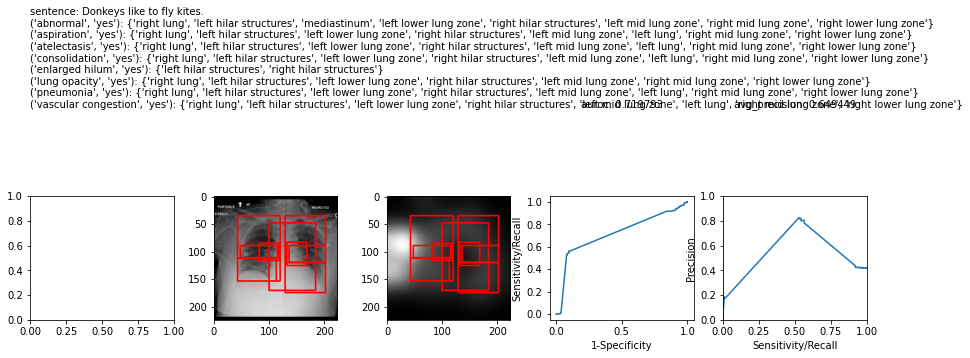

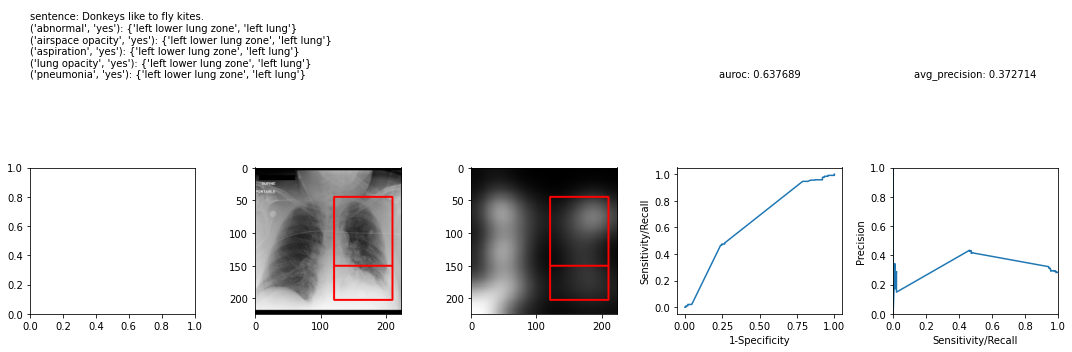

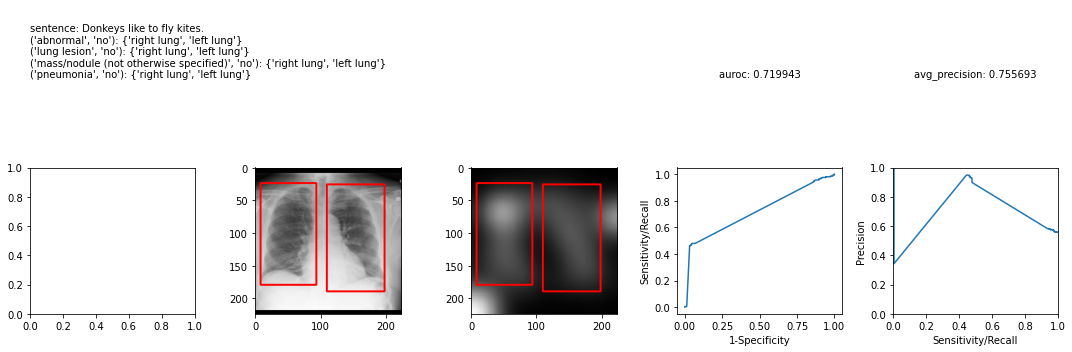

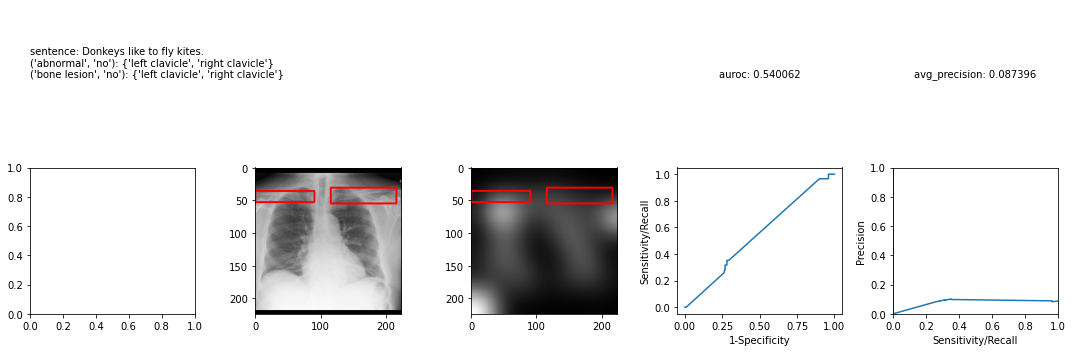

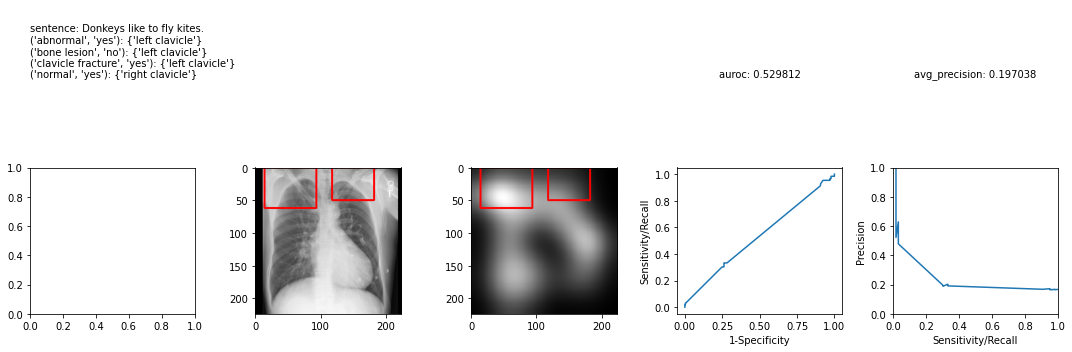

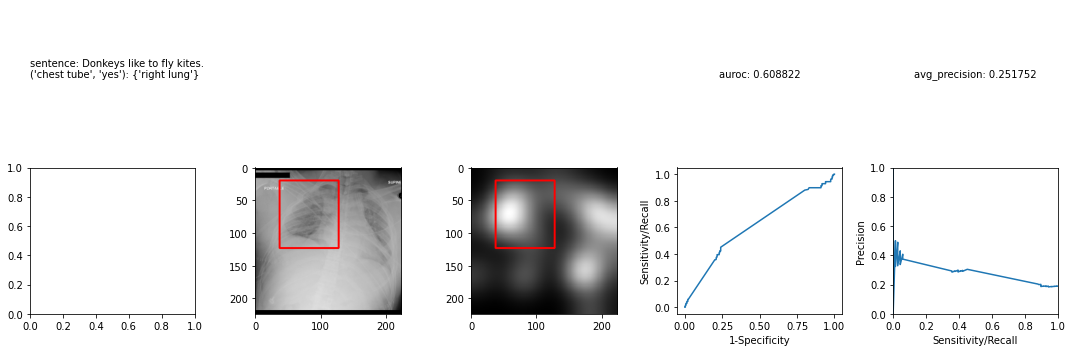

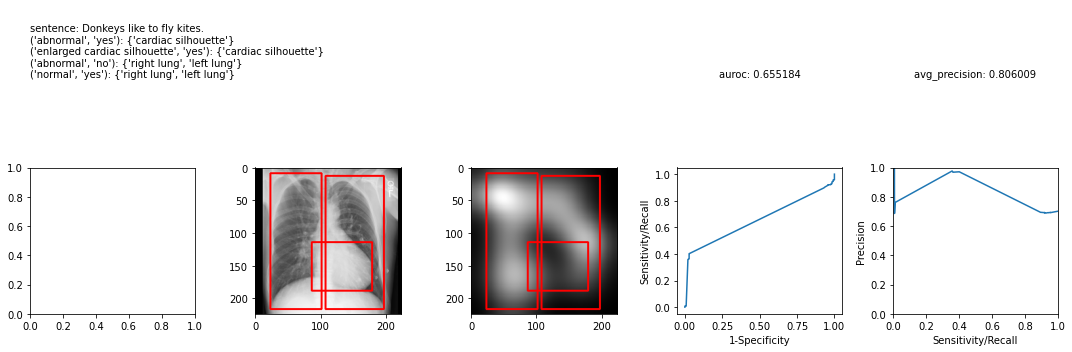

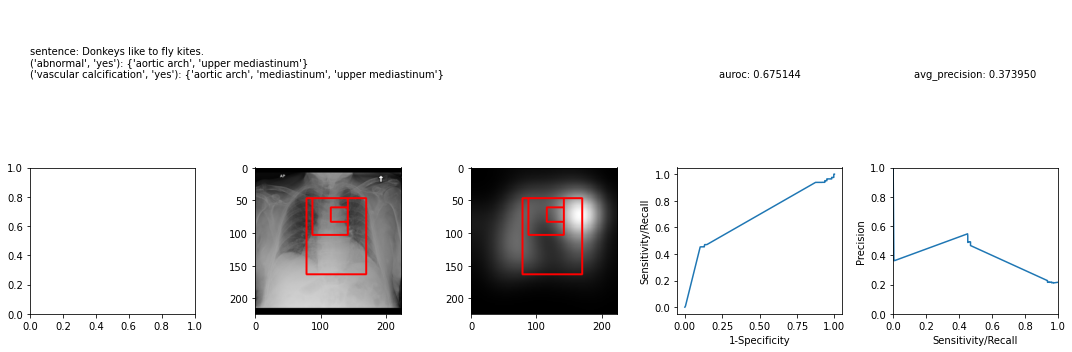

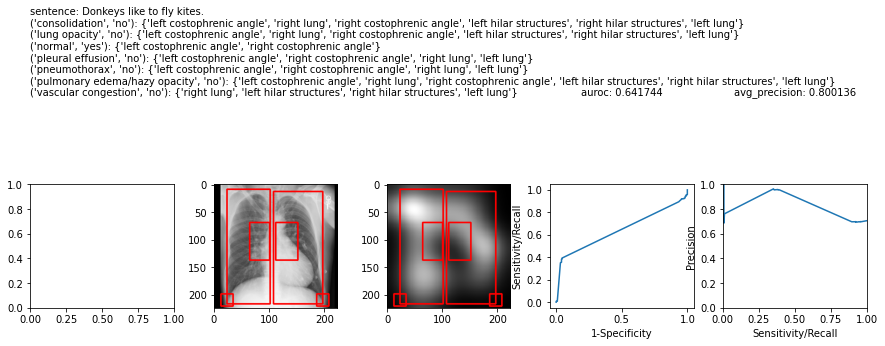

In [32]:
%matplotlib inline
dicom_sent_ids = dfs['original_test_none'].dicom_sent_id[:10]
paths = produce_visual_results(module, gold, dicom_sent_ids, directory='experiments')
plt.close()

In [33]:
visualize(paths)

Innotater(children=(HBox(children=(VBox(children=(Textarea(value='gensent', disabled=True), Textarea(value='di…

In [ ]:
sent_infos = gold[0][18771968][53209617]['objects']['67bd451d-6f695b32-b8ce2be9-23c30cae-f6f94270']['sent_to_bboxes']
print(sent_infos.keys())
sent_info = sent_infos['53209617|5']
print(sent_info['sentence'])
# print(sent_info['labels'])
# print(sent_info['contexts'])
# print(sent_info['bboxes'])
print(gold.sentence_generator(sent_info['labels'], sent_info['contexts'], sent_info['bboxes']))
labels, contexts, bboxes = gold.get_swapped_conditions(sent_info['labels'], sent_info['contexts'], sent_info['bboxes'])
# print(labels)
# print(contexts)
# print(bboxes)
print(gold.sentence_generator(labels, contexts, bboxes))

In [ ]:
l = 10
gold = dm.dm.get_dataset('gold')
results = el.evaluate_and_save(
    path='experiments_reg', instances=[gold[i] for i in tqdm(range(l), total=l)], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')
gold = dm.dm.get_dataset('gold', )
results = el.evaluate_and_save(
    path='experiments_abn', instances=[gold[i] for i in tqdm(range(l), total=l)], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')

In [ ]:
visualize({'regular': 'experiments'})

In [ ]:
visualize(paths, selector=selector)

In [ ]:
from gloria.datasets.mimic_data import save_and_get_all_location_condition_pairs

In [ ]:
save_and_get_all_location_condition_pairs(gold, 'gold_loc_cond_pairs.pkl')

In [ ]:
%debug

In [ ]:
dicom_id = '2533ab2a-565051cb-35201672-0267a457-d931d20f'
sent_id = '55609974|6'
instance = get_instance(dicom_id, sent_id, valid)
display(instance)
el.evaluate_and_save(
    path='experiments2', instances=[instance], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')

In [ ]:
neg_instance = get_instance(dicom_id, sent_id, valid, replace_sent_with='Increased consolidation in the right lung.')
display(neg_instance)
el.evaluate_and_save(
    path='experiments4', instances=[neg_instance], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')

In [ ]:
visualize({'regular': 'experiments', 'reversed': 'experiments_neg'})

In [ ]:
neg_instance = get_instance(dicom_id, sent_id, valid, replace_sent_with='There left lung is normal.')
display(neg_instance)
el.evaluate_and_save(
    path='experiments4', instances=[neg_instance], pl_module=module,
    save_full_data=True, plot=True, plot_attn_overlay_mode='pyramid')

In [ ]:
valid[0]

In [ ]:
gold = dm.dm.get_dataset('gold')

In [ ]:
generate_sentence = GenerateContextLocationConditionSentences()
for i in tqdm(range(len(gold)), total=len(gold)):
    instance = gold[i]
    patient_id = next(iter(instance.keys()))
    study_id = next(iter(instance[patient_id].keys()))
    dicom_id = next(iter(instance[patient_id][study_id]['images'].keys()))
    for k, v in instance[patient_id][study_id]['objects'][dicom_id]['sent_to_bboxes'].items():
        print(v['sentence'])
        print(generate_sentence(v['contexts'], v['bboxes'], v['labels']))
        print()

In [ ]:
set([c for c, _ in valid_label_bbox_pairs])

In [ ]:
set([c for c, _ in valid_label_bbox_pairs])